In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
import gc
from keras import backend as K

Using TensorFlow backend.


# Main configs

In [40]:
loadFromMerged=True
loadFromIndexes= True
Mapper='S'
IgnoreEmpty= False
FoldID ="1"
Epoch_count=3850
Batch_size=19500

# Load the data the old way


In [3]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [4]:
#  mapps the input records to a integer array for the input
def mapping_x( inp ):
    return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1) for x in inp ])

In [5]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )
def mapping_sampling_y(inp):
    return np.random.choice( np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] ))

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

In [6]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S', sampling=False):
    cleans = [] 
    cleans = sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] )
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    
    if sampling: 
        ret_y  = [ mapping_sampling_y(y) for y in ret_y ]
    else :
        if Mapping=='S':
            ret_y  = [ mapping_y_service(y) for y in ret_y ]
        elif Mapping=='SE':
            ret_y  = [ mapping_y_service_event(y) for y in ret_y ]

    
    
    return ret_x, ret_y

In [23]:
x= []
y= []

x_test = {}
y_test = {}

x_train = {}
y_train = {}
import random


if loadFromMerged:
    with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
        x_data = json.load(f)

    if len( y_data ) != len(x_data) :
        print( pick )
    #     continue

    with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
        index_info = json.load(f)
    
    from sklearn.model_selection import StratifiedShuffleSplit
    sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    idx = []
    
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
    
    
    xx , yy =  clean_data( x_data, y_data, IgnoreEmpty , Mapping=Mapper, sampling=True)
    
    xx= np.array(xx)
    yy= np.array(yy)
    for train_idx, test_idx in sss.split( xx,yy ):
        idx.append( [train_idx,test_idx] )
    
    
    
#     for i in  idx[0][1]:
#         x_test[str(i+1)]=( x_data[str(i+1)] )
#         y_test[str(i+1)]=( y_data[str(i+1)] )
    
#     for i in idx[0][0]:
#         x_train[str(i+1)]=(  x_data[str(i+1)] )
#         y_train[str(i+1)]=(  y_data[str(i+1)] )
    
    fname  ='home_os_final.json'
    with open( os.path.join( '../files/train/test/test_homes/final_upload/usecases/hub_segments_final_final/', fname) ) as f:
        y_data_test = json.load(f)

    with open( os.path.join('../files/train/test/test_homes/final_upload/usecases/pcap_segments_final_final/', fname) ) as f:
        x_data_test = json.load(f)


    x_test,y_test= clean_data( x_data_test, y_data_test, IgnoreEmpty , Mapping=Mapper )

    
    
    
    
    
    
#     x_test,y_test= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
    x_train,y_train= clean_data( x_data, y_data, IgnoreEmpty , Mapping=Mapper )

    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
#     indices = np.arange(x_train.shape[0])
#     np.random.shuffle(indices)

#     x_train = x_train[indices]
#     y_train = y_train[indices]
#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in glob.glob( '../files/train/hub_segments/*.json' ):
        fname  = os.path.basename(pick)
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array( x )
y= np.array(y)

len(x_train), len(y_test)

(31273, 19968)

In [24]:
len(idx)

5

In [9]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
idx = []
m = sss.split( xx,yy )

In [32]:
y_train[0]

array(['none'], dtype='<U4')

In [70]:
# np.unique(yy, return_inverse=True)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [10]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,classes=None, twoD= False ):
#  y data 
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            if y in classes:
                temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        if twoD:
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size**2 - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size**2:
                    temp.append( 0 )

                x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


            x_data_temp = np.array( x_data_temp )
            x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
        else: 
            temp = [] 
            lst = list(x)
            for x in x_data:
                temp = [] #list(x)
                lst = list(x)
                while dim_size - len(temp )   > len(lst):
                    temp.extend(lst)

                while len(temp) < dim_size:
                    temp.append( 0 )
                
                x_data_temp.append(np.array( temp))
            
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

# Model Evaluation Methods

In [7]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
    F= 2.0*( prec* recall )/ (prec+recall)
    
    return acc, recall, prec, F
def print_info(y_test, pred , classes, DoPrint=False  ):
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    
    if DoPrint:
        print( "%20s  %8s   %8s  %8s  %8s "  %( "Class","Accuracy",      "Recall","Precision","F Score" ))
        print( "------------------------------------------------------------------------" )
    
        for index in range(len(classes)):
            print( "%20s  %8.3f   %8.3f  %8.3f  %8.3f "  %
                 (classes[index],
                  accs[index][0],
                  accs[index][1],
                  accs[index][2],
                  accs[index][3]
                 )

                 )
    return accs

# Create the Model 

In [12]:
import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2

def unet(dim_size , classcount):
    l2_lambda = 0.0002
    DropP = 0.3
    kernel_size=3

    inputs = Input((dim_size,dim_size,1))
    
    
    conv1 = Conv2D( 32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
    conv1 = bn()(conv1)
    conv1 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)
    conv1 = bn()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(DropP)(pool1)





    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
    conv2 = bn()(conv2)
    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)
    conv2 = bn()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(DropP)(pool2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
    conv3 = bn()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
    conv3 = bn()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(DropP)(pool3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool3)
    conv4 = bn()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
    conv4 = bn()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(DropP)(pool4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
    conv5 = bn()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)
    conv5 = bn()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)
    up6 = Dropout(DropP)(up6)
    conv6 = Conv2D(256,(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
    conv6 = bn()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

    conv6 = bn()(conv6)
    up7 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)
    up7 = Dropout(DropP)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up7)
    conv7 = bn()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)
    conv7 = bn()(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)
    up8 = Dropout(DropP)(up8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up8)
    conv8 = bn()(conv8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)
    conv8 = bn()(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)
    up9 = Dropout(DropP)(up9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
    conv9 = bn()(conv9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
    conv9 = bn()(conv9) 
    
    
    
    flatten1 = Flatten()(conv9)
    conv7 = Dense( 256, activation='relu' )(flatten1)
    conv8 = Dense( 128, activation='relu' )(conv7)
    
    
    output = Dense(classcount,  activation='softmax',name='output')(conv8)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def Do_unet( x_train, y_train , x_test ,y_test, classes ,Batch_size, Epoch_count , return_model=False ):
    dim_size =64
    x_train_processed,y_train_processed, _ = pre_process_raw( x_train, y_train , dim_size, classes=classes)

    model2 = unet(dim_size,len( y_train_processed[0]))
    report2=  model2.fit( x=x_train_processed , y=y_train_processed , batch_size=Batch_size, epochs=Epoch_count , verbose=0)
    
    pred =None
    if x_test is not None:
        x_test_processed,y_test_processed, _ = pre_process_raw( x_test, y_test , dim_size, classes=classes)
        pred= model2.predict( x_test_processed )
    
    if return_model:
        return model2, report2, pred, y_test_processed
    else : 
        K.clear_session()
        del model2
        mx = np.max(report2.history['acc'])
        del report2
        return None, mx, pred, y_test_processed

In [14]:
# model2.save( "UNET_LargeData_F%s_E%d_B%d_M%s_%r" %
#             (
#             FoldID,
#                 Epoch_count,
#                 Batch_size,
#                 Mapper,
#                 IgnoreEmpty
#             ) 
#            )

# Calcualte per class accuracy

In [15]:
# try:
#     print(X_test is None)
#     np.save( "x_test.npy", X_test )
#     np.save("y_test.npy", y_test)
#     np.save("y_pred.npy", pred )
#     np.save("classes.npy", classes)
# except:
#     X_test = np.load("x_test.npy")
#     y_test = np.load("y_test.npy")
#     pred   = np.load("y_pred.npy")
#     classes = np.load("classes.npy")

# Random Forest baseline calc

In [16]:
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [17]:
from sklearn.ensemble import RandomForestClassifier
def Do_RF ( x_train , y_train , x_test , y_test, classes, return_model = False ):
    dim_size= 75
    x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
    
    clf = RandomForestClassifier(n_estimators=260, max_depth=200,
                                 random_state=0 )
    t_hist = clf.fit(x_random_forest_train, y_random_forest_train)

    rf_pred = None 
    if x_test is not None  :
        x_random_forest_test,y_random_forest_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False, classes=classes)
        rf_pred= clf.predict(x_random_forest_test  )

    if return_model : 
        return clf, t_hist, rf_pred, y_random_forest_test
    else : 
        
        del clf
        return None, t_hist, rf_pred, y_random_forest_test


In [18]:
# print_info(y_random_forest_test, rf_pred, classes)

In [19]:
# print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

# LSTM 

In [41]:
# create the model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import Flatten


import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2
from keras.layers import Conv1D
from keras.layers.merge import add
from keras.layers import Dense,Conv1D,Dropout,Activation,BatchNormalization,MaxPooling1D,Flatten,Masking,TimeDistributed
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.models import Input,Sequential,Model
from keras.layers.merge import add
from keras.optimizers import Adam
from keras.losses import MSE,MSLE

def Do_lstm( x_train , y_train , x_test, y_test , Epoch_count ,Batch_size, classes, return_model=False):
    
    
    
    dim_size =15
    x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=False, normalize=False,classes=classes)
#    x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
    x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)
    # create the model
    

        ## Bidirectional LSTM :D 
   
    model2 = Sequential()


    def weighted_categorical_crossentropy(weights):
        """
        A weighted version of keras.objectives.categorical_crossentropy

        Variables:
            weights: numpy array of shape (C,) where C is the number of classes

        Usage:
            weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
            loss = weighted_categorical_crossentropy(weights)
            model.compile(loss=loss,optimizer='adam')
        """

        weights = K.variable(weights)

        def loss(y_true, y_pred):
            # scale predictions so that the class probas of each sample sum to 1
            y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
            # clip to prevent NaN's and Inf's
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            # calc
            loss = y_true * K.log(y_pred) * weights
            loss = -K.sum(loss, -1)
            return loss

        return loss


    import tensorflow as tf

    def f1_perRow(y_true, y_pred):
        tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
        tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
        fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
        fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())
        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        return K.mean(f1)


    def f1_perClass(y_true, y_pred):

        tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
        tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
        fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
        fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())
        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        return K.mean(f1)

    def f1_loss_perClass(y_true, y_pred):

        tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=1)
        tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=1)
        fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=1)
        fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=1)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())
        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        return (1 - K.mean(f1))

    def f1_loss_perRow(y_true, y_pred):

        tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
        tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
        fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
        fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

        p = tp / (tp + fp + K.epsilon())
        r = tp / (tp + fn + K.epsilon())

        f1 = 2*p*r / (p+r+K.epsilon())
        f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
        return (1 - K.mean(f1))




    inputs  = Input( ( dim_size,1 ) )


    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(out)
    # lstm_2 = LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_1 =  Dense(128, activation='relu')(bi_d_1)
    lstm_2 = Dense(128, activation='relu')(lstm_1)



    # td_1    = TimeDistributed(Dense(256, activation='relu'))(lstm_2)
    # dout_1  = Dropout(0.1)(td_1)
    dout_1  = Dropout(0.1)(lstm_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_2  = Dropout(0.2)(dense_1)





    # bi_d_1 = Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat') (inputs)
    lstm_1 =  LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True)(inputs)
    # lstm_1 = LSTM(40 ,  recurrent_dropout=0.14, return_sequences=True)(lstm_1)

    bi_d_raw_1 =Dense(128, activation='relu')  (lstm_1)
    lstm_raw_1 =  Dense(128, activation='relu')(bi_d_raw_1)
    lstm_raw_2 = Dense(128, activation='relu')(lstm_raw_1)

    dout_1  = Dropout(0.1)(lstm_raw_2)
    flt_1   = Flatten()(dout_1)
    dense_1 = Dense(128, activation='relu')(flt_1)
    dout_3  = Dropout(0.2)(dense_1)





    out = Conv1D(128,3,padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling2')(out)


    out = Conv1D(128,3,padding='same')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.2)(out)
    out = Conv1D(128,3,padding='same')(out)
    # out = Flatten()(out)
    # out = MaxPooling1D(2,padding='same', name ='pooling')(out)



    # fl_out_1 = Flatten()(dout_2)

    fl_out_cnn = Flatten()(out)

    # out_new = concatenate( [fl_out_1, fl_out_cnn] , name='mergerguy')
    out_new = concatenate( [dout_2, fl_out_cnn,dout_3] , name='mergerguy')

    dens_out_1 = Dense( 128, activation='relu' )(out_new)
    dens_out_2 = Dense( 128, activation='relu' )(dens_out_1)
    dens_out_3 = Dense( 128, activation='relu' )(dens_out_2)

    # fl2  = Flatten()(out_new)

    out_put_final = Dense(len(classes), activation='sigmoid', name='Event_output')(dens_out_3)

    toService_1 = Dense( 130, name="to_service1" )(dens_out_3)
    toService_1 = Dense( 130, name="to_service2" )(toService_1)

    service_output = Dense(len(classes  ), activation="sigmoid", name = 'service_output')(toService_1)



    model2 = Model(inputs=[inputs], outputs=[service_output])


    losses = {
    #     "service_output": f1_loss_perClass ,
        "service_output": f1_loss_perRow ,
        "service_output": "categorical_crossentropy",
    }
    lossWeights = {#"service_output": 20,
                   "service_output": 30.0 ,
        "service_output": 20}



    model2.compile(loss=losses,loss_weights=lossWeights, optimizer='adam', metrics=[f1_perRow,f1_perClass,'acc'])
    # model2.compile(loss=losses, loss_weights=lossWeights, optimizer='adam', metrics=['accuracy'])

#     print(model2.summary())
    hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=12500, shuffle=True, verbose=0)

    
    if x_test is not None :
        x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=False, normalize=False,classes=classes)
        
#           for tt  in range( len(lstm_tests) ):
        x_lstm_prossed_test= x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1) 
#
        pred = model2.predict( x_lstm_prossed_test )
    
    if return_model:
        return model2 , hist2, pred , y_lstm_prossed_test
    else :

        mx  = np.max(hist2.history['acc'])
        del hist2
        K.clear_session()
        del model2
        return None , mx, pred , y_lstm_prossed_test
    
    
    

In [21]:
_,_ , classes = pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=False)

In [25]:
len(idx)

5

In [42]:
CNNs22 = [] 
lstms22 = []
rfs22 = []

_,_ , classes = pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=False)
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)



    
#     for i in  idx[0][1]:
#         x_test[str(i+1)]=( x_data[str(i+1)] )
#         y_test[str(i+1)]=( y_data[str(i+1)] )
    
#     for i in idx[0][0]:
#         x_train[str(i+1)]=(  x_data[str(i+1)] )
#         y_train[str(i+1)]=(  y_data[str(i+1)] )


for d in idx:  #sss.split( x_train,y_train ):
#     idx.append( [train_idx,test_idx] )
    train_idx = d[0]
    test_idx = d[1]
    
    x_test_t=x_train[test_idx]
    y_test_t = y_train[test_idx]
    
    x_train_t = x_train[train_idx]
    y_train_t = y_train[train_idx]
#     for i in  test_idx:
#         x_test_t[str(i+1)]=( x_data[str(i+1)] )
#         y_test_t[str(i+1)]=( y_data[str(i+1)] )
    
#     for i in train_idx:
#         x_train_t[str(i+1)]=(  x_data[str(i+1)] )
#         y_train_t[str(i+1)]=(  y_data[str(i+1)] )

    
    lstms22.append( Do_lstm(x_train_t, y_train_t, x_test_t, y_test_t, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) )
#     rfs22.append( Do_RF(x_train_t, y_train_t, x_test_t, y_test_t, classes) )
    gc.collect()
    print ("*")
    
    
    
# for i in range( 200,len ( x_train ) ,int( len(x_train)/60) ):
    
#     if i % 1000 == 0:
#         print( "done %d of %d" %( i , len(x_train) ))

*
*
*
*
*


In [43]:
len(x_train)

31273

In [44]:
from sklearn.metrics import accuracy_score
import matplotlib.colors as pltc
from random import sample
def fix_pred(pred):
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    return pred.astype(int)

# acc_cnns = [ print_info( pick[1][3], fix_pred(  pick[1][2]), classes=classes )  for pick in CNNs2  ]
acc_lstm = [ print_info( pick[3], fix_pred(  pick[2]) , classes=classes)  for pick in lstms  ]
acc_lstm2 = [ print_info( pick[3], fix_pred(  pick[2]) , classes=classes)  for pick in lstms22  ]
acc_rf = [ print_info( pick[3], fix_pred(  pick[2]) , classes=classes)  for pick in rfs  ]

# acc_cnn_avg=[ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_cnns]
acc_lstm_avg =[ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_lstm]
acc_lstm_avg2 =[ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_lstm2]
acc_rf_avg = [ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_rf]

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [45]:
acc_lstm_avg2

[array([0.96436535, 0.43534995, 0.28575203, 0.31998005]),
 array([0.962632  , 0.45737337, 0.2615986 , 0.32363122]),
 array([0.96330515, 0.45822244, 0.26713704, 0.32505124]),
 array([0.95600993, 0.50441558, 0.24969892, 0.31959621]),
 array([0.95823131, 0.4821872 , 0.27506706, 0.32217078])]

In [39]:
acc_lstm_avg2

[array([0.95627919, 0.50666636, 0.26345284, 0.32406621]),
 array([0.95399049, 0.51150325, 0.25034614, 0.32177681]),
 array([0.95722159, 0.42825179, 0.22269254, 0.27395308]),
 array([0.96551811, 0.43121628, 0.27339928, 0.3245395 ]),
 array([0.9601666 , 0.41837753, 0.25208863, 0.29237875])]

In [33]:
acc_lstm_avg2

[array([0.95890446, 0.49601258, 0.26989969, 0.33561159]),
 array([0.95383903, 0.50647801, 0.25916276, 0.32762936]),
 array([0.9392486 , 0.5147937 , 0.2162984 , 0.28795305]),
 array([0.95288822, 0.48337117, 0.25114965, 0.31003133]),
 array([0.95926627, 0.42977837, 0.24203797, 0.29519005])]

In [31]:
acc_rf_avg

[array([0.98738693, 0.6237261 , 0.66124256, 0.6083291 ]),
 array([0.987429  , 0.59547473, 0.74732103, 0.60606272]),
 array([0.98702512, 0.59403744, 0.64638371, 0.5944914 ]),
 array([0.98752156, 0.58845133, 0.74399702, 0.59832671]),
 array([0.9870167 , 0.59237964, 0.70028261, 0.60453799])]

In [30]:
acc_lstm_avg

[array([0.96359965, 0.37868616, 0.21825131, 0.27108155]),
 array([0.95529471, 0.51527527, 0.2562399 , 0.32690167]),
 array([0.9559931 , 0.44899773, 0.22046597, 0.28513566]),
 array([0.95484034, 0.47918589, 0.28806534, 0.33249412]),
 array([0.96086499, 0.44673699, 0.2230184 , 0.29233931])]

In [ ]:
CNNs = [] 
lstms = []
rfs = []

_,_ , classes = pre_process_raw( x_train, y_train , 15, zero_pad=True, normalize=False)

for i in range( 200,len ( x_train ) ,int( len(x_train)/60) ):
    
#     CNNs.append( [i, Do_unet(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) ])
    lstms.append( [i,Do_lstm(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) ])
    rfs.append([i, Do_RF(x_train[:i], y_train[:i], x_test, y_test, classes) ])
    gc.collect()
    print ("*")
    if i % 1000 == 0:
        print( "done %d of %d" %( i , len(x_train) ))

In [ ]:
# CNNs2 = [] 
# lstms2 = []
# rfs2 = []

# for i in range(len(CNNs)):
#     CNNs2.append( [ i*200 , CNNs[i]] )
#     lstms2.append( [ i*200 , lstms[i]])
#     rfs2.append( [ i*200 , rfs[i]])

# CNNs = CNNs2
# lstms=lstms2
# rfs = rfs2

In [ ]:
K.clear_session()

In [ ]:

# for k in range÷( 15200,len ( x_train ) , 2000 ):
k= 1
i =15400
while True:
    i = (k*200)+2000 + i 
    k+=10
    if i >= len(x_train) : 
        break 
    CNNs2.append( [i, Do_unet(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size)] )
    lstms2.append([i, Do_lstm(x_train[:i], y_train[:i], x_test, y_test, classes=classes , Epoch_count=Epoch_count, Batch_size=Batch_size) ])
    rfs2.append( [i, Do_RF(x_train[:i], y_train[:i], x_test, y_test, classes) ])
#     gc.collect()
#     print ("*")
#     if i % 1000 == 0:
    print( "done %d of %d" %( i , len(x_train) ))

In [ ]:
len(CNNs2)

In [23]:
CNNs2 = np.array( CNNs )
lstms2 = np.array(lstms)
rfs2  = np.array(rfs)

In [24]:
# np.save( "cnns_final.npy" , CNNs2 )
np.save( "lstms_final.npy", lstms2)
np.save( "rfs_final.npy", rfs2)

In [4]:
# CNNs2 =list( np.load( "cnns2.npy" ))
lstms2 = list(np.load("lstms_final.npy" , allow_pickle=True))
rfs2  = list(np.load("rfs_final.npy", allow_pickle=True))

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.21.dev0 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.21.dev0 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [25]:

_,_ , classes = pre_process_raw( x_train, y_train , 160, zero_pad=True, normalize=False)


In [12]:
classes=['acceleration',
 'activity',
 'battery',
 'button',
 'colorTemperature',
 'contact',
 'level',
 'lock',
 'motion',
 'none',
 'on/off',
 'ping',
 'raw',
 'read_attr_-_raw',
 'status',
 'switch',
 'temperature',
 'threeAxis',
 'water']

In [5]:
plt.plot( [ pick[1][1] for pick in CNNs2  ] )
plt.plot( [ pick[1][1] for pick in lstms2  ] )

NameError: name 'CNNs2' is not defined

In [13]:
from sklearn.metrics import accuracy_score
import matplotlib.colors as pltc
from random import sample
def fix_pred(pred):
    pred[pred>=0.5] = 1
    pred[pred<0.5] = 0
    return pred.astype(int)

# acc_cnns = [ print_info( pick[1][3], fix_pred(  pick[1][2]), classes=classes )  for pick in CNNs2  ]
acc_lstm = [ print_info( pick[1][3], fix_pred(  pick[1][2]) , classes=classes)  for pick in lstms2  ]
acc_rf = [ print_info( pick[1][3], fix_pred(  pick[1][2]) , classes=classes)  for pick in rfs2  ]

# acc_cnn_avg=[ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_cnns]
acc_lstm_avg =[ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_lstm]
acc_rf_avg = [ np.average( np.nan_to_num(x) , axis=0 ) for x in acc_rf]

/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [29]:
print_info( rfs2[-1][1][3],fix_pred(rfs2[-1][1][2]    ), classes=classes, DoPrint=True)

               Class  Accuracy     Recall  Precision   F Score 
------------------------------------------------------------------------
        acceleration     0.989      0.176     0.565     0.268 
            activity     1.000      0.000       nan       nan 
             battery     1.000      0.333     1.000     0.500 
              button     0.998      0.955     0.889     0.921 
    colorTemperature     0.998      0.974     0.950     0.962 
             contact     0.990      0.711     0.791     0.749 
               level     0.990      0.923     0.921     0.922 
                lock     0.996      0.697     0.958     0.807 
              motion     0.995      0.310     0.867     0.456 
                none     0.898      0.930     0.929     0.930 
              on/off     0.981      0.927     0.607     0.734 
                ping     0.999      0.991     0.991     0.991 
                 raw     0.998      1.000     0.545     0.706 
     read_attr_-_raw     0.998      0.000   

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


[(0.9886490807354117,
  0.17567567567567569,
  0.5652173913043478,
  0.2680412371134021),
 (0.9995203836930455, 0.0, nan, nan),
 (0.9996802557953637, 0.3333333333333333, 1.0, 0.5),
 (0.9982414068745004,
  0.9552238805970149,
  0.8888888888888888,
  0.9208633093525178),
 (0.9980815347721822, 0.9743589743589743, 0.95, 0.9620253164556962),
 (0.9902478017585932, 0.7109375, 0.7913043478260869, 0.7489711934156379),
 (0.9896083133493205,
  0.9234449760765551,
  0.9212410501193318,
  0.922341696535245),
 (0.9964828137490008,
  0.696969696969697,
  0.9583333333333334,
  0.8070175438596493),
 (0.9950439648281375,
  0.30952380952380953,
  0.8666666666666667,
  0.45614035087719296),
 (0.8981614708233413,
  0.9299292661361627,
  0.9293130108239452,
  0.9296210363495747),
 (0.9809752198241407,
  0.9265536723163842,
  0.6074074074074074,
  0.7337807606263982),
 (0.9990407673860912, 0.991044776119403, 0.991044776119403, 0.991044776119403),
 (0.9976019184652278, 1.0, 0.5454545454545454, 0.7058823529411

In [30]:
for x in range( len(classes)):
    print( classes[x], acc_rf[-1][x][0], acc_rf[-1][x][1], acc_rf[-1][x][2], acc_rf[-1][x][3] )

acceleration 0.9886490807354117 0.17567567567567569 0.5652173913043478 0.2680412371134021
activity 0.9995203836930455 0.0 nan nan
battery 0.9996802557953637 0.3333333333333333 1.0 0.5
button 0.9982414068745004 0.9552238805970149 0.8888888888888888 0.9208633093525178
colorTemperature 0.9980815347721822 0.9743589743589743 0.95 0.9620253164556962
contact 0.9902478017585932 0.7109375 0.7913043478260869 0.7489711934156379
level 0.9896083133493205 0.9234449760765551 0.9212410501193318 0.922341696535245
lock 0.9964828137490008 0.696969696969697 0.9583333333333334 0.8070175438596493
motion 0.9950439648281375 0.30952380952380953 0.8666666666666667 0.45614035087719296
none 0.8981614708233413 0.9299292661361627 0.9293130108239452 0.9296210363495747
on/off 0.9809752198241407 0.9265536723163842 0.6074074074074074 0.7337807606263982
ping 0.9990407673860912 0.991044776119403 0.991044776119403 0.991044776119403
raw 0.9976019184652278 1.0 0.5454545454545454 0.7058823529411764
read_attr_-_raw 0.99808153

W0912 15:14:02.845047 140305648199488 legend.py:1282] No handles with labels found to put in legend.


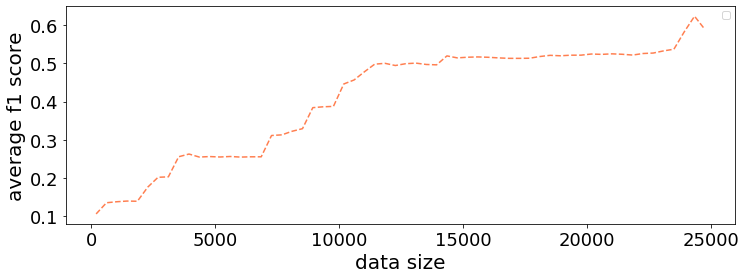

In [14]:
# all_colors = [k for k,v in plt.cnames.items()]
colors = ['coral',
 'sienna',
 'lightcoral',
 'darkgray',
 'lightyellow',
 'tan',
 'sandybrown',
 'cyan',
 'aliceblue',
 'brown',
 'lavender',
 'lavenderblush',
 'palevioletred',
 'tomato',
 'gainsboro',
 'hotpink',
 'olivedrab',
 'mediumvioletred',
 'orangered',
 'forestgreen',
 'lightgreen',
 'navy',
 'darkorchid',
 'seagreen',
 'lime',
 'mediumslateblue']

plt.figure(figsize=(12,4))
# indexes  = [x[0]+200 for x in rfs2  ]  

indexes = [ x[0] for x in rfs2 ]



# for ind in range(len( acc_cnn_avg[0] )):
#     plt.plot([ p[ind] for p in acc_cnn_avg ], c=colors[ind], linestyle='-' , label='cnn_'+ classes[ind])
#     plt.plot([ p[ind] for p in acc_lstm_avg], c=colors[ind], linestyle=':', label='lstm_'+ classes[ind])
#     plt.plot([ p[ind] for p in acc_rf_avg], c=colors[ind], linestyle='--',  label ='rf_'+ classes[ind])
ind =0
# plt.plot(indexes,[ p[2] for p in acc_cnn_avg ], c=colors[ind], linestyle='-' , label='cnn_')
# plt.plot(indexes,[ p[3] for p in acc_lstm_avg], c=colors[ind], linestyle=':', label='lstm_')
plt.plot(indexes,[ p[3] for p in acc_rf_avg], c=colors[ind], linestyle='--',  label ='')
plt.tick_params(axis='both',  labelsize=18)
plt.xlabel( 'data size' ,fontsize=20 )
plt.ylabel( 'average f1 score', fontsize=20)



# for ind in range(len( classes )):
#     plt.plot([ p[ind][3] for p in acc_cnns ], c=colors[ind], linestyle='-' , label='cnn_'+ classes[ind])
#     plt.plot([ p[ind][3] for p in acc_lstm], c=colors[ind], linestyle=':', label='lstm_'+ classes[ind])
#     plt.plot([ p[ind][3] for p in acc_rf], c=colors[ind], linestyle='--',  label ='rf_'+ classes[ind])


# plt.plot([ p[-1][3] for p in acc_cnns ], c=colors[ind], linestyle='-' , label='cnn_'+ classes[ind])
# plt.plot([ p[ind][3] for p in acc_lstm], c=colors[ind], linestyle=':', label='lstm_'+ classes[ind])
# plt.plot([ p[ind][3] for p in acc_rf], c=colors[ind], linestyle='--',  label ='rf_'+ classes[ind])


# def fix_pred(pred):
#     pred[pred>=0.5] = 1
#     pred[pred<0.5] = 0
#     return pred.astype(int)



# acc_cnns = [ accuracy_score( pick[1][3], fix_pred(  pick[1][2]) )  for pick in CNNs2  ]
# acc_lstm = [ accuracy_score( pick[1][3], fix_pred(  pick[1][2]) )  for pick in lstms2  ]
# acc_rf = [ accuracy_score( pick[1][3], fix_pred(  pick[1][2]) )  for pick in rfs2  ]
plt.legend()

In [15]:
data_size_growth = list( zip(indexes,  [ p[3] for p in acc_rf_avg]  )  )

In [17]:
import csv
with open( 'outputs/avg_f1_by_data_size.csv', 'w' ) as f:
    wr = csv.writer(f, quoting=csv.QUOTE_ALL)
    wr.writerows(data_size_growth)

### len(classes)

In [ ]:
v= [   abs(pick[1][3]- fix_pred(  pick[1][2]))  for pick in rfs2  ]

Text(0, 0.5, 'accuracy')

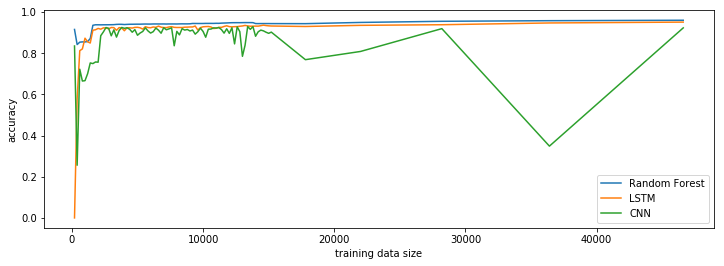

In [16]:
cnn_acc = []
indexes  = [x[0]+200 for x in rfs2  ]    
plt.figure(figsize=(12,4))
lists   = [rfs2,lstms2, CNNs2]
lables = ['Random Forest', 'LSTM', 'CNN']

for i in range(3) :
#     v= [abs(pick[1][3]- fix_pred(  pick[1][2]))  for pick in i  ]
#     xx= np.sum(v[-1],axis=1) 
#     print(len(xx[xx==0])* 1.0/ len(xx))
     
    xx= [np.sum(cc ,axis=1)  for cc in [abs(pick[1][3]- fix_pred(  pick[1][2]))  for pick in lists[i]  ]]
    xx= [ len(p[p==0])* 1.0/ 12590 for p in xx  ]
    plt.plot(indexes,xx, label =lables[i] )
    
plt.legend()
plt.xlabel('training data size')
plt.ylabel('accuracy')


In [ ]:
a = np.array([1,2,2,4,4,5,56,6,6,0,0,0]). ( lambda x: x>0 )

In [ ]:
len(v[0]), len(xx)

In [ ]:
['coral',
 'sienna',
 'lightcoral',
 'darkgray',
 'lightyellow',
 'tan',
 'sandybrown',
 'cyan',
 'aliceblue',
 'brown',
 'lavender',
 'lavenderblush',
 'palevioletred',
 'tomato',
 'gainsboro',
 'hotpink',
 'olivedrab',
 'mediumvioletred',
 'orangered',
 'forestgreen',
 'lightgreen',
 'navy',
 'darkorchid',
 'seagreen',
 'lime',
 'mediumslateblue']

In [ ]:
x_train[0]

In [ ]:
y_train[0]